In [1]:
student_id = '20224258'
model_name = '20224258'

In [2]:
from competition_utils import *
from training_args import *

model_name = f'submission_{model_name}'
module_path = f"models.submission_{student_id}.{model_name}"
module = importlib.import_module(module_path)
globals()[model_name] = getattr(module, model_name)

Project_Name = 'Competition'
model_dir = 'models'
output_root = 'output'

SAVE_RESULT = True
SAVE_N = 1500
vis_root = f'vis/TEST_OUTPUTS_{datetime.now().strftime("%y%m%d_%H%M%S")}'

Dataset_root = 'Datasets'
Dataset_Name_list = [
                    #  'VOC',
                     'ETIS',
                     'CVPPP',
                     'CFD',
                     'CarDD',
]
number_of_classes_dict = {'VOC':21,
                          'ETIS':2,
                          'CVPPP':2,
                          'CFD':2,
                          'CarDD':2
                         }
epochs = 30
EARLY_STOP = 100
batch_size = 16
EXCLUDE_BACKGROUND = True
BINARY_SEG = None
THRESHOLD = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"

=== Learning Rate 변화 분석 시작 ===
📊 Learning Rate 변화 계산 중...
✅ 30 epoch 동안의 Learning Rate 변화 계산 완료


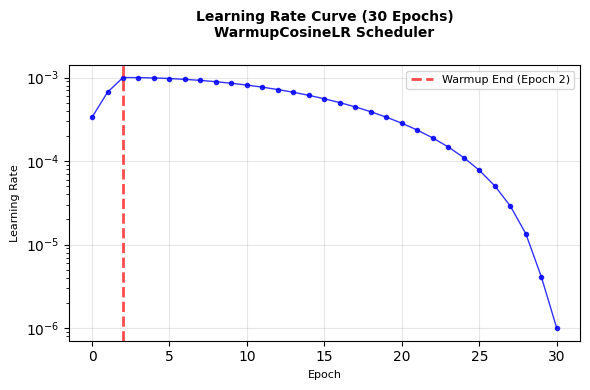


✅ Learning Rate 분석 완료!


In [3]:
# ==================== Learning Rate 변화 추적 및 시각화 ====================
import matplotlib.pyplot as plt
import numpy as np
import torch

print("=== Learning Rate 변화 분석 시작 ===")

# 더미 모델과 옵티마이저 생성 (실제 학습 설정과 동일하게)
print("📊 Learning Rate 변화 계산 중...")

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(1, 1)
    def parameters(self):
        return [torch.nn.Parameter(torch.zeros(1))]

dummy_model = DummyModel()
optimizer = Make_Optimizer(dummy_model)
lr_scheduler = Make_LR_Scheduler(optimizer)

# 30 epoch 동안의 learning rate 변화 기록
epochs_list = []
lr_values = []

# 초기 learning rate 기록
current_lr = optimizer.param_groups[0]['lr']
epochs_list.append(0)
lr_values.append(current_lr)

# 각 epoch마다 scheduler step 실행하며 learning rate 기록
for epoch in range(1, epochs + 1):
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs_list.append(epoch)
    lr_values.append(current_lr)

print(f"✅ {epochs} epoch 동안의 Learning Rate 변화 계산 완료")

# Learning Rate 변화 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(epochs_list, lr_values, 'b-', linewidth=1, marker='o', markersize=3, alpha=0.8)
plt.title(f'Learning Rate Curve (30 Epochs)\n{lr_scheduler.__class__.__name__} Scheduler', 
          fontsize=10, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Learning Rate', fontsize=8)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 로그 스케일로 표시

# Warmup 구간 표시 (있는 경우)
if hasattr(lr_scheduler, 'warmup_iters') and lr_scheduler.warmup_iters > 0:
    warmup_epochs = lr_scheduler.warmup_iters
    plt.axvline(x=warmup_epochs, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Warmup End (Epoch {warmup_epochs})')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.close()  # 메모리 절약을 위해 close

print(f"\n✅ Learning Rate 분석 완료!")


In [4]:
now = datetime.now()
Experiments_Time=now.strftime("%y%m%d_%H%M%S")
print('Experiment Start Time:',Experiments_Time)
eval_columns=['Experiment Time','Train Time', 'Dataset Name', 'Model Name', 'Val Loss', 'Test Loss', 'IoU', 'Dice',  'Precision', 'Recall', 'Total Params','Train-Predction Time']
df = pd.DataFrame(index=None, columns=eval_columns)
output_root = f'{output_root}/output_{Experiments_Time}'
os.makedirs(output_root, exist_ok = True)
seed = iteration = 1
for j, Dataset_Name in enumerate(Dataset_Name_list):
    print(f'Dataset: {Dataset_Name} ({j+1}/{len(Dataset_Name_list)})')
    control_random_seed(seed)
    Dataset_dir = Dataset_root+'/'+Dataset_Name
    Height, Width = (256, 256)
    in_channels = 3
    number_of_classes = number_of_classes_dict[Dataset_Name]
    BINARY_SEG = True if number_of_classes==2 else False
    exclude_background = EXCLUDE_BACKGROUND
    out_channels = 1 if BINARY_SEG else number_of_classes

    train_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Originals/*"))
    train_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Masks/*"))
    validation_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Originals/*"))
    validation_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Masks/*"))
    test_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Originals/*"))
    test_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Masks/*"))
    print(f'train/val/test: {len(train_image_path_list)}/{len(validation_image_path_list)}/{len(test_image_path_list)}')

    # train_dataset = ImagesDataset(train_image_path_list, train_target_path_list, augment=False)
    train_dataset = ImagesDataset(train_image_path_list, train_target_path_list)
    validation_dataset = ImagesDataset(validation_image_path_list, validation_target_path_list)
    test_dataset = ImagesDataset(test_image_path_list, test_target_path_list)
    train_loader = SegDataLoader(
    train_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, shuffle=True, drop_last=True, fill_last_batch=False,
    )
    validation_loader = SegDataLoader(
        validation_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )
    test_loader = SegDataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )

    print(f'{model_name}', end=' ')
    print(f'Dataset: {Dataset_Name}) ({j+1}/{len(Dataset_Name_list)})', end=' ')
    output_dir = output_root + f'/{model_name}_{Dataset_Name}'
    control_random_seed(seed)
    model=globals()[model_name](in_channels, out_channels)
    model = model.to(device)
    optimizer = Make_Optimizer(model)
    lr_scheduler = Make_LR_Scheduler(optimizer)
    criterion = Make_Loss_Function(number_of_classes)
    if SAVE_RESULT==True:
        os.makedirs(vis_root+f"/{Dataset_Name}", exist_ok=True)
    df = Execute_Experiment(model_name, model, Dataset_Name, train_loader, validation_loader, test_loader, 
                            optimizer, lr_scheduler, criterion, number_of_classes, df, epochs, device, output_dir,
                           BINARY_SEG, exclude_background, out_channels, seed, THRESHOLD, EARLY_STOP, SAVE_RESULT, vis_root+f"/{Dataset_Name}", Experiments_Time
                           )
    df.to_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', index=False, header=True, encoding="cp949")

Experiment Start Time: 250617_083028
Dataset: ETIS (1/4)
train/val/test: 118/39/39
submission_20224258 Dataset: ETIS) (1/4) Training Start Time: 250617_083028


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

1EP(250617_083031): T_Loss: 3.268236 V_Loss: 3.277832 IoU: 0.0382 Best Epoch: 1 Loss: 3.277832


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

2EP(250617_083033): T_Loss: 3.256574 V_Loss: 3.270998 IoU: 0.0382 Best Epoch: 2 Loss: 3.270998


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

3EP(250617_083036): T_Loss: 3.237525 V_Loss: 3.247311 IoU: 0.0382 Best Epoch: 3 Loss: 3.247311


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

4EP(250617_083038): T_Loss: 3.234427 V_Loss: 3.214128 IoU: 0.0319 Best Epoch: 4 Loss: 3.214128


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

5EP(250617_083040): T_Loss: 3.223496 V_Loss: 3.204285 IoU: 0.0439 Best Epoch: 5 Loss: 3.204285


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

6EP(250617_083042): T_Loss: 3.210444 V_Loss: 3.205229 IoU: 0.0769 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

7EP(250617_083045): T_Loss: 3.209462 V_Loss: 3.201290 IoU: 0.0751 Best Epoch: 7 Loss: 3.201290


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

8EP(250617_083047): T_Loss: 3.202078 V_Loss: 3.194673 IoU: 0.0866 Best Epoch: 8 Loss: 3.194673


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

9EP(250617_083049): T_Loss: 3.191397 V_Loss: 3.186583 IoU: 0.0808 Best Epoch: 9 Loss: 3.186583


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

10EP(250617_083051): T_Loss: 3.184619 V_Loss: 3.179694 IoU: 0.0766 Best Epoch: 10 Loss: 3.179694


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

11EP(250617_083054): T_Loss: 3.167610 V_Loss: 3.173991 IoU: 0.0884 Best Epoch: 11 Loss: 3.173991


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

12EP(250617_083056): T_Loss: 3.165139 V_Loss: 3.162357 IoU: 0.0855 Best Epoch: 12 Loss: 3.162357


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

13EP(250617_083058): T_Loss: 3.160926 V_Loss: 3.152701 IoU: 0.0760 Best Epoch: 13 Loss: 3.152701


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

14EP(250617_083100): T_Loss: 3.156965 V_Loss: 3.150115 IoU: 0.1036 Best Epoch: 14 Loss: 3.150115


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

15EP(250617_083103): T_Loss: 3.140485 V_Loss: 3.135391 IoU: 0.0588 Best Epoch: 15 Loss: 3.135391


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

16EP(250617_083105): T_Loss: 3.141872 V_Loss: 3.131213 IoU: 0.0781 Best Epoch: 16 Loss: 3.131213


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

17EP(250617_083107): T_Loss: 3.139612 V_Loss: 3.128420 IoU: 0.0862 Best Epoch: 17 Loss: 3.128420


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

18EP(250617_083109): T_Loss: 3.132195 V_Loss: 3.123060 IoU: 0.0578 Best Epoch: 18 Loss: 3.123060


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

19EP(250617_083112): T_Loss: 3.125603 V_Loss: 3.121811 IoU: 0.0845 Best Epoch: 19 Loss: 3.121811


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

20EP(250617_083114): T_Loss: 3.123389 V_Loss: 3.118189 IoU: 0.0992 Best Epoch: 20 Loss: 3.118189


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

21EP(250617_083116): T_Loss: 3.120830 V_Loss: 3.117540 IoU: 0.1232 Best Epoch: 21 Loss: 3.117540


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

22EP(250617_083119): T_Loss: 3.121969 V_Loss: 3.114832 IoU: 0.1209 Best Epoch: 22 Loss: 3.114832


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

23EP(250617_083121): T_Loss: 3.120442 V_Loss: 3.109480 IoU: 0.0949 Best Epoch: 23 Loss: 3.109480


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

24EP(250617_083123): T_Loss: 3.120624 V_Loss: 3.107564 IoU: 0.0860 Best Epoch: 24 Loss: 3.107564


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

25EP(250617_083125): T_Loss: 3.109324 V_Loss: 3.108456 IoU: 0.0930 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

26EP(250617_083128): T_Loss: 3.113511 V_Loss: 3.109354 IoU: 0.1016 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

27EP(250617_083130): T_Loss: 3.118204 V_Loss: 3.109155 IoU: 0.1037 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

28EP(250617_083132): T_Loss: 3.111827 V_Loss: 3.108819 IoU: 0.1047 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

29EP(250617_083134): T_Loss: 3.111313 V_Loss: 3.108311 IoU: 0.1034 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

30EP(250617_083137): T_Loss: 3.101986 V_Loss: 3.108135 IoU: 0.1020 
Test Start Time: 250617_083137


Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Best Epoch: 24
Test(250617_083148): Loss: 3.088047 IoU: 0.1197 Dice: 0.1597 Precision: 0.3628 Recall: 0.1480
End 250617_083148
Dataset: CVPPP (2/4)
train/val/test: 486/162/162
submission_20224258 Dataset: CVPPP) (2/4) Training Start Time: 250617_083148


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

1EP(250617_083156): T_Loss: 3.008854 V_Loss: 2.935341 IoU: 0.1994 Best Epoch: 1 Loss: 2.935341


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

2EP(250617_083204): T_Loss: 2.962664 V_Loss: 2.844236 IoU: 0.6558 Best Epoch: 2 Loss: 2.844236


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

3EP(250617_083212): T_Loss: 2.916076 V_Loss: 2.791691 IoU: 0.7744 Best Epoch: 3 Loss: 2.791691


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

4EP(250617_083219): T_Loss: 2.862798 V_Loss: 2.747722 IoU: 0.8214 Best Epoch: 4 Loss: 2.747722


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

5EP(250617_083227): T_Loss: 2.814907 V_Loss: 2.712948 IoU: 0.8294 Best Epoch: 5 Loss: 2.712948


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

6EP(250617_083235): T_Loss: 2.775922 V_Loss: 2.671140 IoU: 0.8613 Best Epoch: 6 Loss: 2.671140


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

7EP(250617_083243): T_Loss: 2.745754 V_Loss: 2.630728 IoU: 0.8693 Best Epoch: 7 Loss: 2.630728


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

8EP(250617_083250): T_Loss: 2.712260 V_Loss: 2.605499 IoU: 0.8819 Best Epoch: 8 Loss: 2.605499


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

9EP(250617_083258): T_Loss: 2.690076 V_Loss: 2.583647 IoU: 0.8755 Best Epoch: 9 Loss: 2.583647


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

10EP(250617_083306): T_Loss: 2.672695 V_Loss: 2.563691 IoU: 0.8671 Best Epoch: 10 Loss: 2.563691


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

11EP(250617_083314): T_Loss: 2.651984 V_Loss: 2.545901 IoU: 0.8732 Best Epoch: 11 Loss: 2.545901


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

12EP(250617_083321): T_Loss: 2.643246 V_Loss: 2.536477 IoU: 0.8682 Best Epoch: 12 Loss: 2.536477


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

13EP(250617_083329): T_Loss: 2.630524 V_Loss: 2.527569 IoU: 0.8795 Best Epoch: 13 Loss: 2.527569


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

14EP(250617_083337): T_Loss: 2.623356 V_Loss: 2.520704 IoU: 0.8836 Best Epoch: 14 Loss: 2.520704


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

15EP(250617_083345): T_Loss: 2.615361 V_Loss: 2.515742 IoU: 0.8741 Best Epoch: 15 Loss: 2.515742


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

16EP(250617_083352): T_Loss: 2.610934 V_Loss: 2.511011 IoU: 0.8837 Best Epoch: 16 Loss: 2.511011


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

17EP(250617_083400): T_Loss: 2.610398 V_Loss: 2.507943 IoU: 0.8842 Best Epoch: 17 Loss: 2.507943


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

18EP(250617_083408): T_Loss: 2.606790 V_Loss: 2.504454 IoU: 0.8771 Best Epoch: 18 Loss: 2.504454


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

19EP(250617_083416): T_Loss: 2.601680 V_Loss: 2.501954 IoU: 0.8801 Best Epoch: 19 Loss: 2.501954


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

20EP(250617_083423): T_Loss: 2.600111 V_Loss: 2.499896 IoU: 0.8823 Best Epoch: 20 Loss: 2.499896


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

21EP(250617_083431): T_Loss: 2.598806 V_Loss: 2.498783 IoU: 0.8863 Best Epoch: 21 Loss: 2.498783


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

22EP(250617_083439): T_Loss: 2.598952 V_Loss: 2.497660 IoU: 0.8850 Best Epoch: 22 Loss: 2.497660


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

23EP(250617_083447): T_Loss: 2.591316 V_Loss: 2.497018 IoU: 0.8849 Best Epoch: 23 Loss: 2.497018


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

24EP(250617_083454): T_Loss: 2.598745 V_Loss: 2.495978 IoU: 0.8839 Best Epoch: 24 Loss: 2.495978


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

25EP(250617_083502): T_Loss: 2.597083 V_Loss: 2.495459 IoU: 0.8808 Best Epoch: 25 Loss: 2.495459


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

26EP(250617_083510): T_Loss: 2.593905 V_Loss: 2.494583 IoU: 0.8883 Best Epoch: 26 Loss: 2.494583


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

27EP(250617_083518): T_Loss: 2.594743 V_Loss: 2.494853 IoU: 0.8836 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

28EP(250617_083525): T_Loss: 2.594850 V_Loss: 2.494759 IoU: 0.8794 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

29EP(250617_083533): T_Loss: 2.591961 V_Loss: 2.494582 IoU: 0.8824 Best Epoch: 29 Loss: 2.494582


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

30EP(250617_083541): T_Loss: 2.591350 V_Loss: 2.494736 IoU: 0.8829 
Test Start Time: 250617_083541


Test:   0%|          | 0/11 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250617_083629): Loss: 2.520416 IoU: 0.8711 Dice: 0.9236 Precision: 0.9813 Recall: 0.8862
End 250617_083629
Dataset: CFD (3/4)
train/val/test: 70/24/24
submission_20224258 Dataset: CFD) (3/4) Training Start Time: 250617_083629


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

1EP(250617_083630): T_Loss: 3.245765 V_Loss: 3.265662 IoU: 0.0091 Best Epoch: 1 Loss: 3.265662


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

2EP(250617_083632): T_Loss: 3.236318 V_Loss: 3.262147 IoU: 0.0091 Best Epoch: 2 Loss: 3.262147


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

3EP(250617_083633): T_Loss: 3.225766 V_Loss: 3.253912 IoU: 0.0091 Best Epoch: 3 Loss: 3.253912


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

4EP(250617_083635): T_Loss: 3.215744 V_Loss: 3.238479 IoU: 0.0091 Best Epoch: 4 Loss: 3.238479


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

5EP(250617_083637): T_Loss: 3.208452 V_Loss: 3.221490 IoU: 0.0094 Best Epoch: 5 Loss: 3.221490


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

6EP(250617_083638): T_Loss: 3.202574 V_Loss: 3.212027 IoU: 0.0092 Best Epoch: 6 Loss: 3.212027


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

7EP(250617_083640): T_Loss: 3.196205 V_Loss: 3.219947 IoU: 0.0133 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

8EP(250617_083642): T_Loss: 3.191968 V_Loss: 3.206742 IoU: 0.0109 Best Epoch: 8 Loss: 3.206742


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

9EP(250617_083643): T_Loss: 3.187264 V_Loss: 3.199200 IoU: 0.0071 Best Epoch: 9 Loss: 3.199200


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

10EP(250617_083645): T_Loss: 3.177159 V_Loss: 3.194072 IoU: 0.0056 Best Epoch: 10 Loss: 3.194072


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

11EP(250617_083647): T_Loss: 3.174895 V_Loss: 3.185973 IoU: 0.0093 Best Epoch: 11 Loss: 3.185973


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

12EP(250617_083648): T_Loss: 3.170833 V_Loss: 3.179854 IoU: 0.0275 Best Epoch: 12 Loss: 3.179854


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

13EP(250617_083650): T_Loss: 3.165651 V_Loss: 3.164114 IoU: 0.0565 Best Epoch: 13 Loss: 3.164114


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

14EP(250617_083651): T_Loss: 3.163583 V_Loss: 3.155502 IoU: 0.0703 Best Epoch: 14 Loss: 3.155502


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

15EP(250617_083653): T_Loss: 3.161754 V_Loss: 3.155378 IoU: 0.0860 Best Epoch: 15 Loss: 3.155378


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

16EP(250617_083655): T_Loss: 3.154522 V_Loss: 3.154838 IoU: 0.1161 Best Epoch: 16 Loss: 3.154838


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

17EP(250617_083656): T_Loss: 3.153209 V_Loss: 3.152819 IoU: 0.1599 Best Epoch: 17 Loss: 3.152819


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

18EP(250617_083658): T_Loss: 3.148522 V_Loss: 3.149230 IoU: 0.2006 Best Epoch: 18 Loss: 3.149230


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

19EP(250617_083700): T_Loss: 3.145422 V_Loss: 3.146535 IoU: 0.2239 Best Epoch: 19 Loss: 3.146535


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

20EP(250617_083701): T_Loss: 3.143459 V_Loss: 3.144352 IoU: 0.2313 Best Epoch: 20 Loss: 3.144352


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

21EP(250617_083703): T_Loss: 3.144095 V_Loss: 3.142433 IoU: 0.2372 Best Epoch: 21 Loss: 3.142433


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

22EP(250617_083704): T_Loss: 3.142401 V_Loss: 3.141290 IoU: 0.2404 Best Epoch: 22 Loss: 3.141290


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

23EP(250617_083706): T_Loss: 3.138206 V_Loss: 3.140207 IoU: 0.2433 Best Epoch: 23 Loss: 3.140207


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

24EP(250617_083708): T_Loss: 3.140831 V_Loss: 3.139203 IoU: 0.2447 Best Epoch: 24 Loss: 3.139203


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

25EP(250617_083709): T_Loss: 3.139871 V_Loss: 3.138856 IoU: 0.2453 Best Epoch: 25 Loss: 3.138856


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

26EP(250617_083711): T_Loss: 3.135025 V_Loss: 3.138686 IoU: 0.2474 Best Epoch: 26 Loss: 3.138686


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

27EP(250617_083713): T_Loss: 3.141135 V_Loss: 3.138338 IoU: 0.2467 Best Epoch: 27 Loss: 3.138338


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

28EP(250617_083714): T_Loss: 3.141036 V_Loss: 3.138343 IoU: 0.2469 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

29EP(250617_083716): T_Loss: 3.138517 V_Loss: 3.138169 IoU: 0.2477 Best Epoch: 29 Loss: 3.138169


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

30EP(250617_083718): T_Loss: 3.139582 V_Loss: 3.138065 IoU: 0.2480 Best Epoch: 30 Loss: 3.138065
Test Start Time: 250617_083718


Test:   0%|          | 0/2 [00:00<?, ?batch/s]

Best Epoch: 30
Test(250617_083724): Loss: 3.137516 IoU: 0.1968 Dice: 0.3002 Precision: 0.4668 Recall: 0.2790
End 250617_083724
Dataset: CarDD (4/4)
train/val/test: 310/104/104
submission_20224258 Dataset: CarDD) (4/4) Training Start Time: 250617_083724


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

1EP(250617_083729): T_Loss: 3.054222 V_Loss: 3.062176 IoU: 0.1186 Best Epoch: 1 Loss: 3.062176


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

2EP(250617_083734): T_Loss: 3.033773 V_Loss: 3.060467 IoU: 0.1251 Best Epoch: 2 Loss: 3.060467


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

3EP(250617_083739): T_Loss: 3.010854 V_Loss: 3.008783 IoU: 0.2008 Best Epoch: 3 Loss: 3.008783


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

4EP(250617_083744): T_Loss: 2.991120 V_Loss: 2.969800 IoU: 0.2552 Best Epoch: 4 Loss: 2.969800


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

5EP(250617_083750): T_Loss: 2.970130 V_Loss: 2.955257 IoU: 0.2615 Best Epoch: 5 Loss: 2.955257


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

6EP(250617_083755): T_Loss: 2.951686 V_Loss: 2.929976 IoU: 0.2690 Best Epoch: 6 Loss: 2.929976


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

7EP(250617_083800): T_Loss: 2.934096 V_Loss: 2.917045 IoU: 0.2761 Best Epoch: 7 Loss: 2.917045


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

8EP(250617_083805): T_Loss: 2.915709 V_Loss: 2.901063 IoU: 0.2643 Best Epoch: 8 Loss: 2.901063


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

9EP(250617_083810): T_Loss: 2.898426 V_Loss: 2.891007 IoU: 0.2706 Best Epoch: 9 Loss: 2.891007


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

10EP(250617_083815): T_Loss: 2.885042 V_Loss: 2.879309 IoU: 0.2730 Best Epoch: 10 Loss: 2.879309


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

11EP(250617_083820): T_Loss: 2.867939 V_Loss: 2.861924 IoU: 0.2130 Best Epoch: 11 Loss: 2.861924


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

12EP(250617_083825): T_Loss: 2.857923 V_Loss: 2.843417 IoU: 0.1120 Best Epoch: 12 Loss: 2.843417


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

13EP(250617_083831): T_Loss: 2.847560 V_Loss: 2.848576 IoU: 0.2544 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

14EP(250617_083836): T_Loss: 2.836761 V_Loss: 2.845879 IoU: 0.2679 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

15EP(250617_083841): T_Loss: 2.827834 V_Loss: 2.832930 IoU: 0.2662 Best Epoch: 15 Loss: 2.832930


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

16EP(250617_083846): T_Loss: 2.820056 V_Loss: 2.826441 IoU: 0.2309 Best Epoch: 16 Loss: 2.826441


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

17EP(250617_083851): T_Loss: 2.813536 V_Loss: 2.821716 IoU: 0.2275 Best Epoch: 17 Loss: 2.821716


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

18EP(250617_083856): T_Loss: 2.806404 V_Loss: 2.814143 IoU: 0.2003 Best Epoch: 18 Loss: 2.814143


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

19EP(250617_083901): T_Loss: 2.799288 V_Loss: 2.819050 IoU: 0.2754 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

20EP(250617_083907): T_Loss: 2.797602 V_Loss: 2.809498 IoU: 0.2142 Best Epoch: 20 Loss: 2.809498


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

21EP(250617_083912): T_Loss: 2.796214 V_Loss: 2.813628 IoU: 0.2622 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

22EP(250617_083917): T_Loss: 2.791928 V_Loss: 2.804279 IoU: 0.1784 Best Epoch: 22 Loss: 2.804279


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

23EP(250617_083922): T_Loss: 2.786800 V_Loss: 2.806971 IoU: 0.2309 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

24EP(250617_083927): T_Loss: 2.788176 V_Loss: 2.807949 IoU: 0.2409 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

25EP(250617_083932): T_Loss: 2.787115 V_Loss: 2.805299 IoU: 0.2477 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

26EP(250617_083937): T_Loss: 2.786771 V_Loss: 2.803466 IoU: 0.2404 Best Epoch: 26 Loss: 2.803466


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

27EP(250617_083943): T_Loss: 2.783458 V_Loss: 2.802487 IoU: 0.2281 Best Epoch: 27 Loss: 2.802487


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

28EP(250617_083948): T_Loss: 2.783422 V_Loss: 2.803193 IoU: 0.2394 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

29EP(250617_083953): T_Loss: 2.783415 V_Loss: 2.802832 IoU: 0.2394 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

30EP(250617_083958): T_Loss: 2.780826 V_Loss: 2.803878 IoU: 0.2467 
Test Start Time: 250617_083958


Test:   0%|          | 0/7 [00:00<?, ?batch/s]

Best Epoch: 27
Test(250617_084026): Loss: 2.807816 IoU: 0.2436 Dice: 0.3499 Precision: 0.5002 Recall: 0.3613
End 250617_084026


In [5]:
# 우회를 위한 prefix 제거
model_name = model_name.replace('submission_', '')

In [ ]:
# 결과 분석 및 데이터 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV 파일 읽기
results_df = pd.read_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', encoding='cp949')

print("\n=== 실험 결과 요약 ===")
print(f"모델: {results_df['Model Name'].unique()}")
print(f"\n=== 모델 파라미터 정보 ===")
if 'Total Params' in results_df.columns:
    total_params = results_df['Total Params'].iloc[1]  # 모든 실험에서 같은 모델 사용
    total_params = int(total_params.replace(',',''))
    print("총 파라미터 수: {:,}".format(total_params))

# 2. 각 데이터셋별 IoU 결과
print(f"\n=== 데이터셋별 IoU 결과 ===")
dataset_results = results_df[['Dataset Name', 'IoU', 'Dice', 'Precision', 'Recall']].copy()
dataset_results = dataset_results.round(4)
print(dataset_results.to_string(index=False))

# 3. Mean IoU 계산
mean_iou = results_df['IoU'].mean()
print(f"\n=== 전체 성능 요약 ===")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {results_df['Dice'].mean():.4f}")
print(f"Mean Precision: {results_df['Precision'].mean():.4f}")
print(f"Mean Recall: {results_df['Recall'].mean():.4f}")

# 상세 결과 테이블
print(f"\n=== 상세 실험 결과 ===")
display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
print(display_df.to_string(index=False))



=== 실험 결과 요약 ===
모델: ['submission_20224258']

=== 모델 파라미터 정보 ===
총 파라미터 수: 21,210

=== 데이터셋별 IoU 결과 ===
Dataset Name    IoU   Dice  Precision  Recall
        ETIS 0.1197 0.1597     0.3628  0.1480
       CVPPP 0.8711 0.9236     0.9813  0.8862
         CFD 0.1968 0.3002     0.4668  0.2790
       CarDD 0.2436 0.3499     0.5002  0.3613

=== 전체 성능 요약 ===
Mean IoU: 0.3578
Mean Dice: 0.4334
Mean Precision: 0.5778
Mean Recall: 0.4186

=== 상세 실험 결과 ===
Dataset Name          Model Name    IoU   Dice  Precision  Recall Total Params
        ETIS submission_20224258 0.1197 0.1597     0.3628  0.1480       21,210
       CVPPP submission_20224258 0.8711 0.9236     0.9813  0.8862       21,210
         CFD submission_20224258 0.1968 0.3002     0.4668  0.2790       21,210
       CarDD submission_20224258 0.2436 0.3499     0.5002  0.3613       21,210


In [7]:
# Global CSV에 결과 저장 (파라미터 사이즈와 Mean IoU만)
global_csv_path = 'results.csv'
global_result = {
    'Model_Name': [model_name],
    'Experiment_Time': [Experiments_Time],
    'Total_Params': [total_params],
    'Mean_IoU': [mean_iou]
}
global_df = pd.DataFrame(global_result)

# 기존 global CSV가 있으면 읽어서 추가, 없으면 새로 생성
if os.path.exists(global_csv_path):
    existing_global_df = pd.read_csv(global_csv_path)
    global_df = pd.concat([existing_global_df, global_df], ignore_index=True)

global_df.to_csv(global_csv_path, index=False)
print(f"\n=== Global 결과 저장 완료 ===")
print(f"저장 경로: {global_csv_path}")
print(f"누적 실험 수: {len(global_df)}")

# Global CSV 내용 확인
print(f"\n=== Global CSV 현재 내용 ===")
print(global_df.to_string(index=False))



=== Global 결과 저장 완료 ===
저장 경로: results.csv
누적 실험 수: 19

=== Global CSV 현재 내용 ===
Model_Name Experiment_Time  Total_Params  Mean_IoU
  Baseline   250612_020604       7763041  0.387735
  Baseline   250612_022650       7763041  0.385343
     LCNet   250612_031035        508258  0.258133
     LCNet   250612_032355        508258  0.274923
     LCNet   250612_033942        508258  0.179640
  Baseline   250612_232032       7763041  0.453180
    LEDNet   250613_004419        918105  0.120133
     SINet   250613_015805        212226  0.175864
     SINet   250613_021114        212226  0.150565
     LCNet   250616_184055        508258  0.244885
  20224258   250616_225703         29921  0.248373
  20224258   250616_231122         18763  0.220652
  20224258   250617_000718          2968  0.205779
  20224258   250617_002327          5460  0.207724
  20224258   250617_003750          9359  0.225064
  20224258   250617_005022          9359  0.221182
  20224258   250617_010503          1596  0.213568


In [8]:
# ==================== Core Metrics CSV 저장 ====================
# Core metrics를 별도 CSV로 저장
core_metrics_path = f'{output_root}/core_metrics_{Experiments_Time}.csv'

core_metrics_data = pd.DataFrame({
    'Student ID': [student_id],
    'Model Name': [model_name],
    'Experiment Time': [Experiments_Time],
    'Mean IoU': [round(mean_iou, 4)],
    'Total Params': [total_params]
})

core_metrics_data.to_csv(core_metrics_path, index=False, encoding='utf-8')
print(f"\n=== Core Metrics CSV 저장 완료 ===")
print(f"저장 경로: {core_metrics_path}")
print(f"\nCore Metrics 내용:")
print(core_metrics_data.to_string(index=False))

# ==================== Detail Metrics CSV 저장 ====================
# 상세 결과 테이블 출력
# Core metrics를 별도 CSV로 저장
detail_metrics_path = f'{output_root}/detail_metrics_{Experiments_Time}.csv'

display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
display_df['Total Params'] = display_df['Total Params'].str.replace(',','').astype(int)

display_df.to_csv(detail_metrics_path, index=False)
print(f"\n=== Detail Metrics CSV 저장 완료 ===")
print(f"저장 경로: {detail_metrics_path}")
print(f"\nDetail Metrics 내용:")
print(display_df.to_string(index=False))


=== Core Metrics CSV 저장 완료 ===
저장 경로: output/output_250617_083028/core_metrics_250617_083028.csv

Core Metrics 내용:
Student ID Model Name Experiment Time  Mean IoU  Total Params
  20224258   20224258   250617_083028    0.3578         21210

=== Detail Metrics CSV 저장 완료 ===
저장 경로: output/output_250617_083028/detail_metrics_250617_083028.csv

Detail Metrics 내용:
Dataset Name          Model Name    IoU   Dice  Precision  Recall  Total Params
        ETIS submission_20224258 0.1197 0.1597     0.3628  0.1480         21210
       CVPPP submission_20224258 0.8711 0.9236     0.9813  0.8862         21210
         CFD submission_20224258 0.1968 0.3002     0.4668  0.2790         21210
       CarDD submission_20224258 0.2436 0.3499     0.5002  0.3613         21210


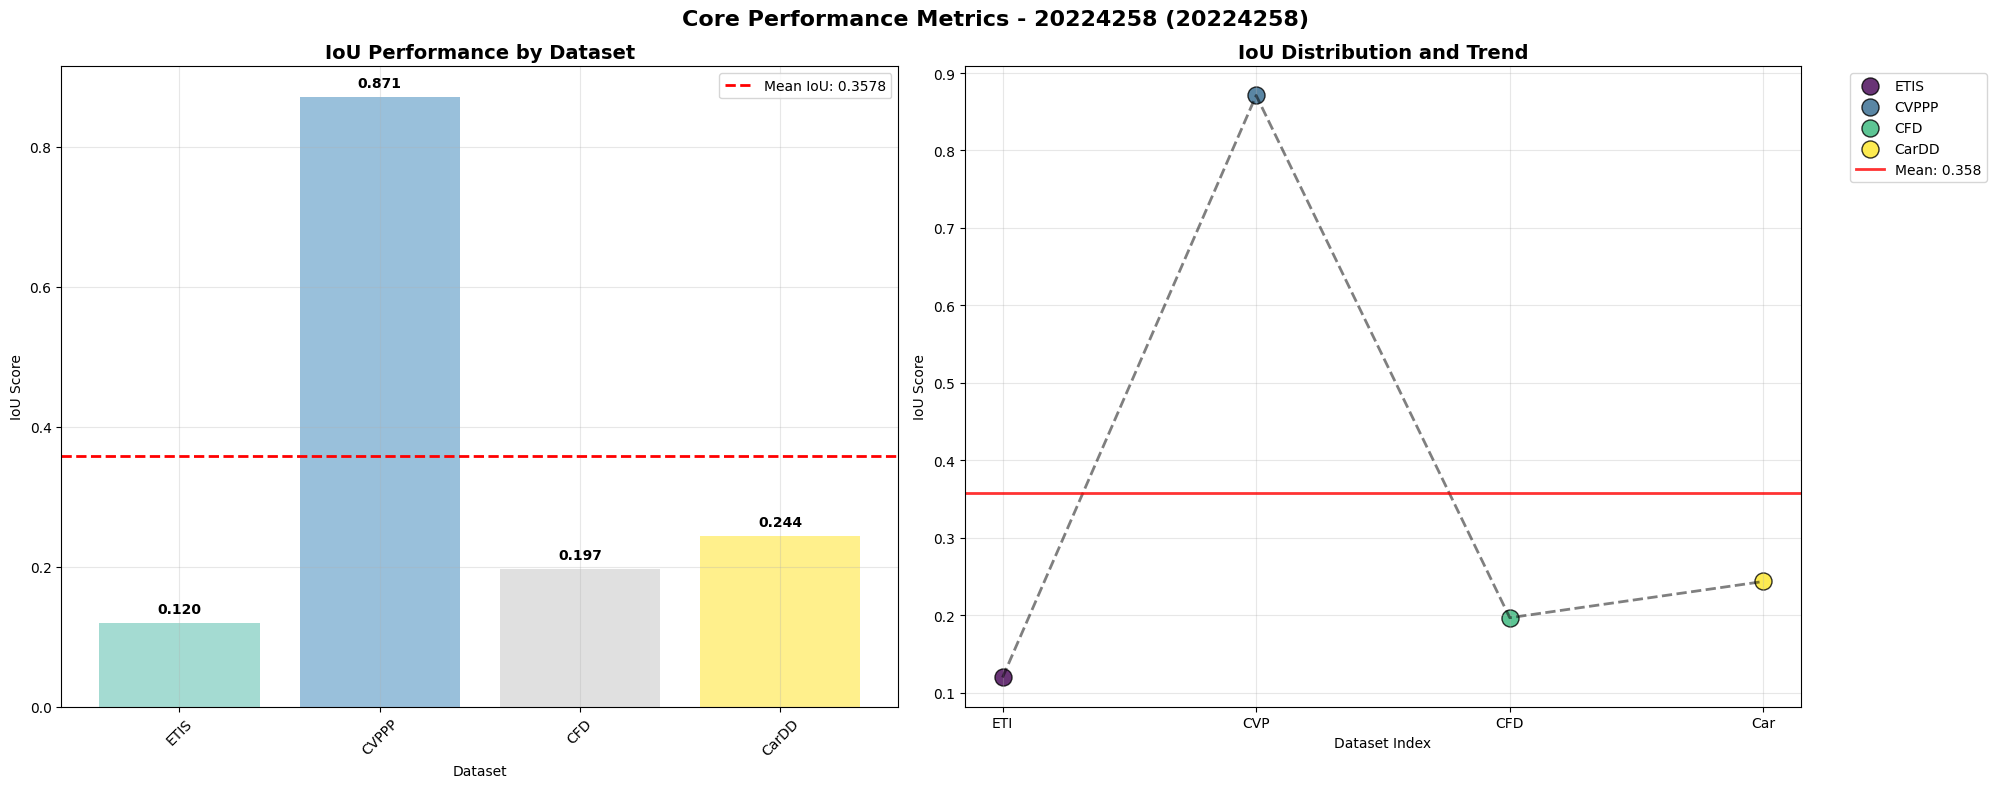

In [9]:
# ==================== 첫 번째 장: 핵심 지표 시각화 ====================
plt.figure(figsize=(20, 8))
plt.suptitle(f'Core Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 1-1. 각 데이터셋별 IoU (바 차트)
plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
bars = plt.bar(results_df['Dataset Name'], results_df['IoU'], color=colors, alpha=0.8)
plt.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
plt.title('IoU Performance by Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('IoU Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, results_df['IoU']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 1-2. IoU 분포 (레이더 차트 스타일)
plt.subplot(1, 2, 2)
datasets = results_df['Dataset Name'].tolist()
iou_scores = results_df['IoU'].tolist()

# 색상 맵 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for i, (dataset, iou, color) in enumerate(zip(datasets, iou_scores, colors)):
    plt.scatter(i, iou, s=150, c=[color], alpha=0.8, label=dataset, edgecolors='black', linewidth=1)

plt.plot(range(len(datasets)), iou_scores, 'k--', alpha=0.5, linewidth=2)
plt.axhline(y=mean_iou, color='red', linestyle='-', alpha=0.8, linewidth=2,
            label=f'Mean: {mean_iou:.3f}')
plt.title('IoU Distribution and Trend', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Index')
plt.ylabel('IoU Score')
plt.xticks(range(len(datasets)), [d[:3] for d in datasets])  # 줄여서 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'core_performance_{Experiments_Time}.png')
plt.show()

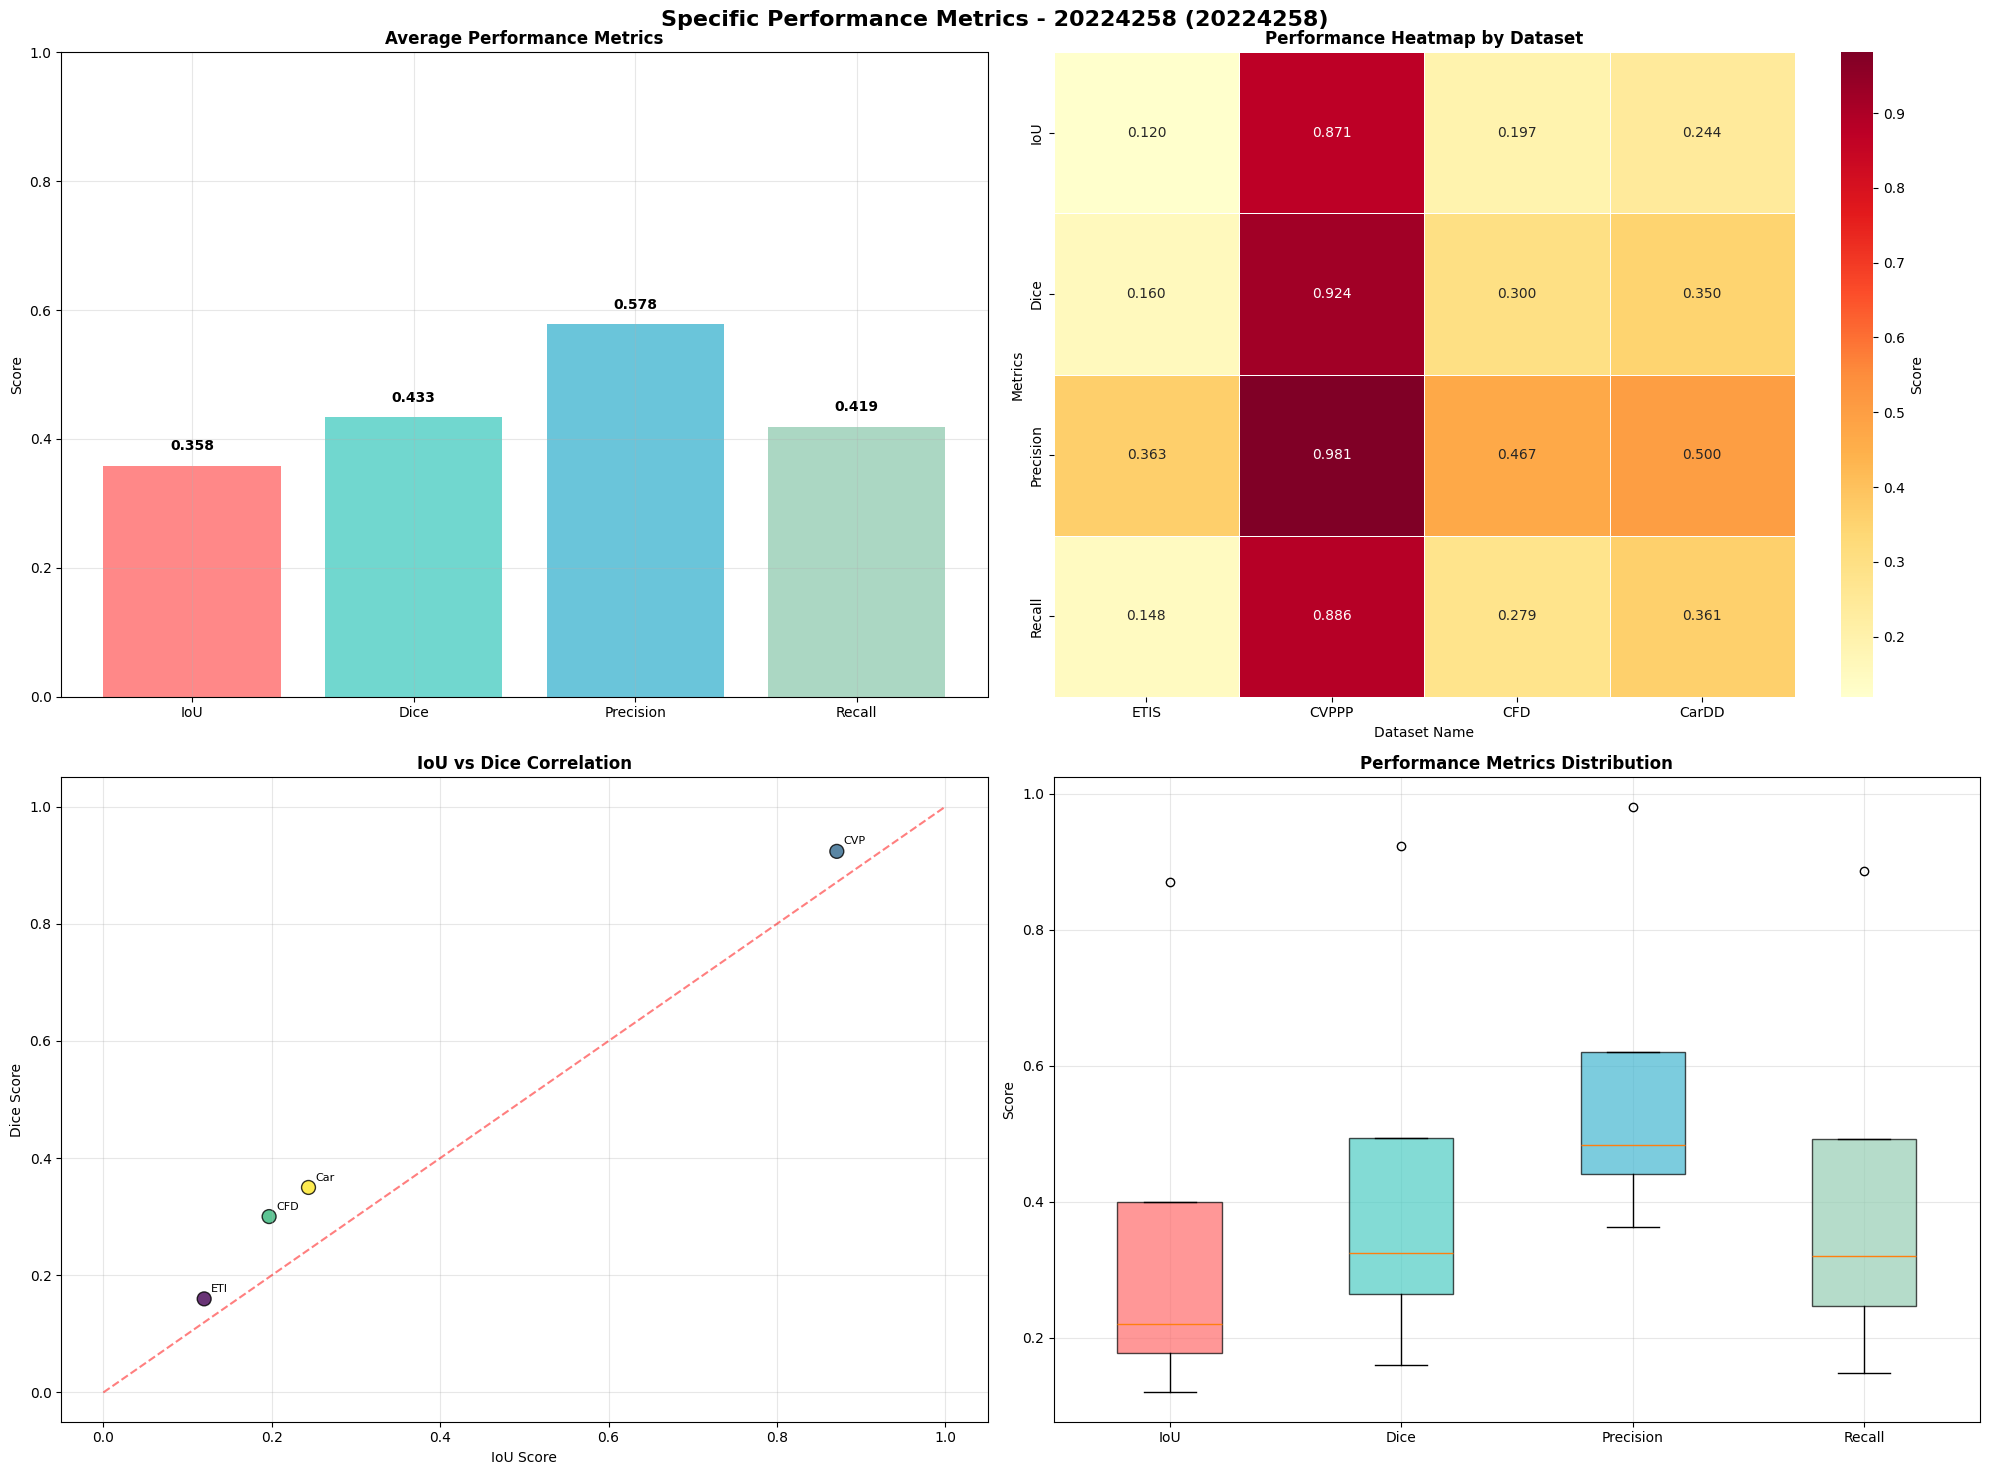

In [10]:
# ==================== 두 번째 장: 상세 분석 ====================
plt.figure(figsize=(20, 15))
plt.suptitle(f'Specific Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 2-1. 전체 성능 지표 비교
plt.subplot(2, 2, 1)
metrics = ['IoU', 'Dice', 'Precision', 'Recall']
values = [results_df[metric].mean() for metric in metrics]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Average Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2-2. 데이터셋별 성능 히트맵
plt.subplot(2, 2, 2)
heatmap_data = results_df[['IoU', 'Dice', 'Precision', 'Recall']].T
heatmap_data.columns = results_df['Dataset Name']

sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Performance Heatmap by Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Metrics')

# 2-3. IoU vs Dice 상관관계
plt.subplot(2, 2, 3)
plt.scatter(results_df['IoU'], results_df['Dice'], c=range(len(results_df)), 
           cmap='viridis', s=100, alpha=0.8, edgecolors='black')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # 대각선
plt.xlabel('IoU Score')
plt.ylabel('Dice Score')
plt.title('IoU vs Dice Correlation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 각 점에 데이터셋 이름 표시
for i, dataset in enumerate(results_df['Dataset Name']):
    plt.annotate(dataset[:3], (results_df['IoU'].iloc[i], results_df['Dice'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2-4. 성능 지표별 분포
plt.subplot(2, 2, 4)
metrics_data = []
metrics_labels = []
for metric in ['IoU', 'Dice', 'Precision', 'Recall']:
    metrics_data.append(results_df[metric].tolist())
    metrics_labels.append(metric)

box_plot = plt.boxplot(metrics_data, labels=metrics_labels, patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Performance Metrics Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'detail_performance_{Experiments_Time}.png')
plt.show()


In [11]:
# === 마지막 셀: 실험 내역 요약 & Markdown 저장 (샘플 이미지, 그래프, Core/Detail CSV 테이블 포함) ===
import glob, importlib.util, torch
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd

# 1) Performance Metrics
metrics_summary = {
    'Mean IoU': mean_iou,
    'Mean Dice': results_df['Dice'].mean(),
    'Mean Precision': results_df['Precision'].mean(),
    'Mean Recall': results_df['Recall'].mean(),
    'Total Params': total_params
}

# 2) 샘플 이미지 (최대 4개)
sample_images = glob.glob(f"{vis_root}/*/*.png")[:4]

# 3) 분석용 그래프 이미지 (output_root/*.png)
graph_images = glob.glob(f"{output_root}/*.png")

# 4) Core & Detail CSV 경로 자동 탐색
csv_files = glob.glob(f"{output_root}/*.csv")
core_csv_path   = next((p for p in csv_files if 'core'   in Path(p).name.lower()), None)
detail_csv_path = next((p for p in csv_files if 'detail' in Path(p).name.lower()), None)

# 5) CSV 읽기
core_df   = pd.read_csv(core_csv_path)   if core_csv_path   else pd.DataFrame()
detail_df = pd.read_csv(detail_csv_path) if detail_csv_path else pd.DataFrame()

# 6) training_args.py 동적 로드
spec = importlib.util.spec_from_file_location('training_args', 'training_args.py')
training_args = importlib.util.module_from_spec(spec)
spec.loader.exec_module(training_args)

# 7) 더미 모델 생성 후 옵티마이저/스케줄러/손실 함수 인스턴스
class _Dummy(torch.nn.Module):
    def parameters(self): return [torch.nn.Parameter(torch.zeros(1))]
dummy = _Dummy()
opt     = training_args.Make_Optimizer(dummy)
sch     = training_args.Make_LR_Scheduler(opt)

# Binary와 Multiclass 두 경우 모두 생성
loss_fn_binary = training_args.Make_Loss_Function(2)    # Binary case (클래스 수 = 2)
loss_fn_multi  = training_args.Make_Loss_Function(21)   # Multiclass case (VOC 21클래스)

# 8) 하이퍼파라미터 추출
opt_params = {k: v for k,v in opt.defaults.items() if k in ('lr','momentum','weight_decay','betas','eps')}
sch_params = {
    'type':      sch.__class__.__name__,
    'T_max':     getattr(sch, 'T_max', None),
    'warmup':    getattr(sch, 'warmup_iters', None),
    'eta_min':   getattr(sch, 'eta_min', None),
    'power':     getattr(sch, 'power', None),
}
# Binary와 Multiclass loss function 정보 추출
def extract_loss_params(loss_fn, case_name):
    params = {'type': loss_fn.__class__.__name__, 'case': case_name}
    for attr in ('alpha','gamma','weight','ignore_index','mode'):
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params

loss_params_binary = extract_loss_params(loss_fn_binary, 'Binary (2 classes)')
loss_params_multi = extract_loss_params(loss_fn_multi, 'Multiclass (21 classes)')

# 9) Markdown 조립
md_lines = [
    '# 📝 실험 내역 요약',
    '## ▶ Performance Metrics'
]
for k,v in metrics_summary.items():
    if k == 'Total Params':
        md_lines.append(f"- **{k}**: `{v:,}`")  # 쉼표 형식으로 표시
    else:
        md_lines.append(f"- **{k}**: `{v:.4f}`")

# 그래프 이미지
md_lines += ['', '## ▶ 분석용 그래프']
for img in graph_images:
    img_name = Path(img).name
    md_lines.append(f"![{img_name}]({img_name})")

# Core CSV 테이블
if not core_df.empty:
    md_lines += ['', '## ▶ Core Metrics']
    # DataFrame.to_markdown() 로 생성된 텍스트를 한 줄씩 추가
    md_lines += core_df.to_markdown(index=False).split('\n')

# Detail CSV 테이블
if not detail_df.empty:
    md_lines += ['', '## ▶ Detail Metrics']
    md_lines += detail_df.to_markdown(index=False).split('\n')

# Hyperparameters
md_lines += ['', '## ▶ Hyperparameters']
md_lines.append(f"### Optimizer ({opt.__class__.__name__})")
for k,v in opt_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"### Scheduler ({sch_params.pop('type')})")
for k,v in sch_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

# Loss Functions (Binary & Multiclass)
md_lines.append("### Loss Functions")

md_lines.append(f"#### Binary Case ({loss_params_binary.pop('type')})")
for k,v in loss_params_binary.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"#### Multiclass Case ({loss_params_multi.pop('type')})")
for k,v in loss_params_multi.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_text = '\n'.join(md_lines)

# 10) 화면에 출력
#display(Markdown(md_text))

# 11) Markdown 파일로 저장
output_dir = Path(output_root)
output_dir.mkdir(parents=True, exist_ok=True)
md_path = output_dir / f"experiment_summary_{Experiments_Time}.md"
md_path.write_text(md_text, encoding='utf-8')

print(f"✅ Markdown 요약이 저장되었습니다: {md_path}")


✅ Markdown 요약이 저장되었습니다: output/output_250617_083028/experiment_summary_250617_083028.md
